<a href="https://colab.research.google.com/github/aftabrakinsad/Research-work/blob/master/Leaf_Disease_Detection_Using_Convolutional_Neural_Networks_A_Proposed_Model_Using_Tomato_Plant_Leaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as plt
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import HTML
from urllib.request import urlopen
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [ ]:
!unzip /content/drive/MyDrive/tomato_dataset3.zip

In [ ]:
for dirname, _, filenames in os.walk('/content/tomato_dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=40

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/tomato_dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6000 files belonging to 6 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Mosaic_virus',
 'Tomato_healthy']

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape) # that batch has 32 images with 256*256 size and RGB
    print(label_batch.numpy()) # printing all the labels of those 32 images

    for image_batch, label_batch in dataset.take(1):
     print(image_batch[0].numpy())

(64, 256, 256, 3)
[0 3 2 5 1 1 4 2 1 1 3 1 2 2 0 2 2 2 3 2 1 3 4 2 3 0 5 3 2 2 2 5 1 0 5 5 3
 5 2 2 2 0 3 0 1 4 5 1 4 3 3 3 2 3 3 3 0 0 5 3 0 1 1 3]
[[[127. 116. 133.]
  [120. 109. 126.]
  [111. 100. 117.]
  ...
  [102.  85. 101.]
  [ 78.  61.  77.]
  [ 88.  71.  87.]]

 [[122. 111. 128.]
  [136. 125. 142.]
  [131. 120. 137.]
  ...
  [ 97.  80.  96.]
  [ 96.  79.  95.]
  [112.  95. 111.]]

 [[104.  93. 110.]
  [111. 100. 117.]
  [104.  93. 110.]
  ...
  [ 82.  65.  81.]
  [ 76.  59.  75.]
  [ 72.  55.  71.]]

 ...

 [[148. 139. 160.]
  [142. 133. 154.]
  [137. 128. 149.]
  ...
  [106.  93. 111.]
  [106.  93. 111.]
  [106.  93. 111.]]

 [[138. 129. 150.]
  [128. 119. 140.]
  [113. 104. 125.]
  ...
  [105.  92. 110.]
  [104.  91. 109.]
  [102.  89. 107.]]

 [[134. 125. 146.]
  [142. 133. 154.]
  [137. 128. 149.]
  ...
  [108.  95. 113.]
  [105.  92. 110.]
  [103.  90. 108.]]]


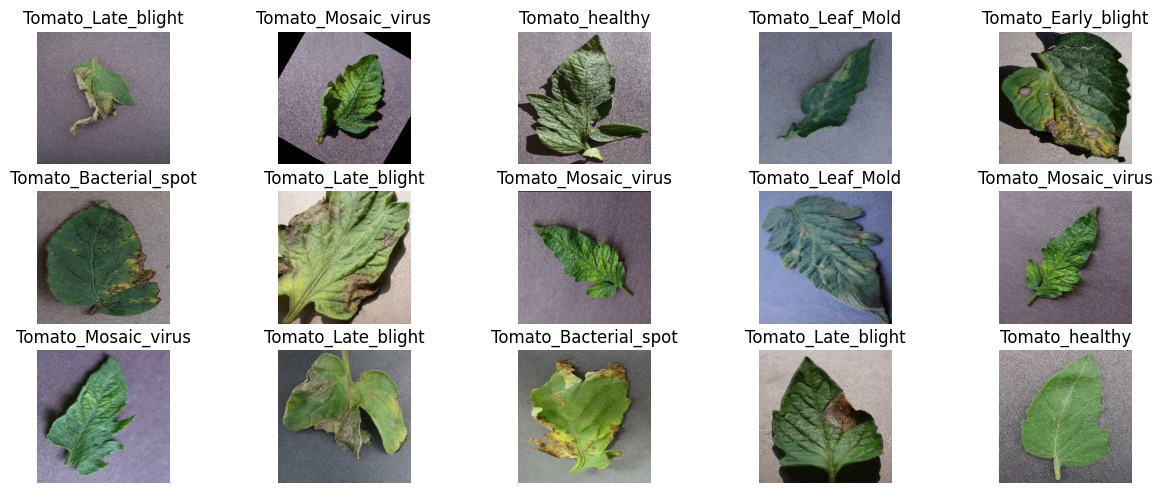

In [ ]:
plt.figure(figsize=(15, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

train_size = 0.8
len(dataset)*train_size

train_ds = dataset.take(100)
len(train_ds)

test_ds = dataset.skip(100)
len(test_ds)

val_size=0.1
len(dataset)*val_size

val_ds = test_ds.take(12)
len(val_ds)

test_ds = test_ds.skip(12)
len(test_ds)

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

75

In [ ]:
len(val_ds)

9

In [ ]:
len(test_ds)

10

In [ ]:
train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

In [ ]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', input_shape=input_shape), ##(3,3) kernal size
    layers.MaxPooling2D((2, 2)), ## pooling window size

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',  input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',  input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',  input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',  input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    #layers.Conv2D(64,  kernel_size = (3,3), activation='relu',  input_shape=input_shape),
    #layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [ ]:
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (64, 254, 254, 64)        1792      
                                                                 
 max_pooling2d_5 (MaxPoolin  (64, 127, 127, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (64, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (64, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (64, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
75/75 [==============================] - 87s 946ms/step - loss: 1.6451 - accuracy: 0.2899 - val_loss: 1.6458 - val_accuracy: 0.3924
Epoch 2/50
75/75 [==============================] - 56s 747ms/step - loss: 1.1068 - accuracy: 0.5650 - val_loss: 0.8826 - val_accuracy: 0.6858
Epoch 3/50
75/75 [==============================] - 51s 686ms/step - loss: 0.7710 - accuracy: 0.7084 - val_loss: 1.2009 - val_accuracy: 0.6250
Epoch 4/50
75/75 [==============================] - 55s 733ms/step - loss: 0.5853 - accuracy: 0.7872 - val_loss: 1.1454 - val_accuracy: 0.6476
Epoch 5/50
75/75 [==============================] - 52s 697ms/step - loss: 0.5423 - accuracy: 0.8035 - val_loss: 0.9901 - val_accuracy: 0.6771
Epoch 6/50
75/75 [==============================] - 50s 667ms/step - loss: 0.4963 - accuracy: 0.8230 - val_loss: 0.5785 - val_accuracy: 0.7865
Epoch 7/50
75/75 [==============================] - 54s 715ms/step - loss: 0.3638 - accuracy: 0.8683 - val_loss: 0.5473 - val_accuracy: 0.8212

In [ ]:
scores = model.evaluate(test_ds)

75/75 [==============================] - 46s 613ms/step - loss: 0.0242 - accuracy: 0.9921


In [ ]:
model.save('tomato_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('/content/tomato_model.h5')

In [ ]:
history
history.params
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])
len(history.history['loss'])

50

In [ ]:
history.history['accuracy'][:5]

[0.2899247407913208,
 0.5650083422660828,
 0.7084029912948608,
 0.7872073650360107,
 0.8035116791725159]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

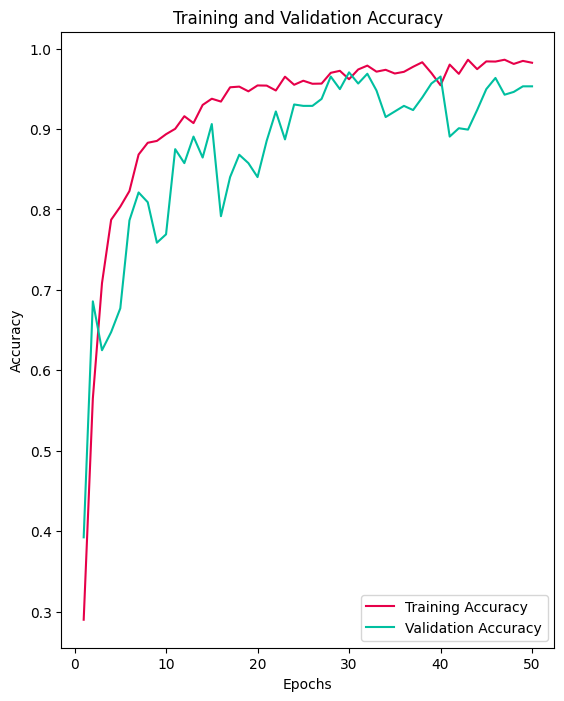

In [ ]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
epochs_range = range(1, len(acc) + 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='#e60049')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#00bfa0')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

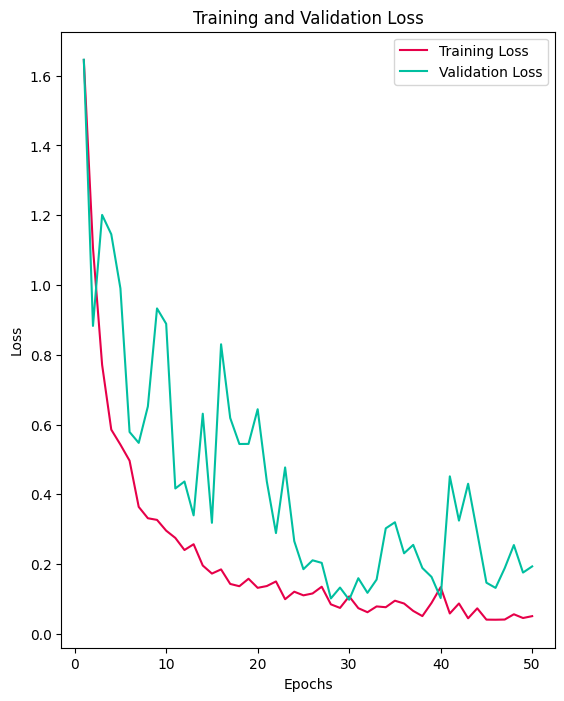

In [ ]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
epochs_range = range(1, len(loss) + 1)
plt.plot(epochs_range, loss, label='Training Loss', color='#e60049')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='#00bfa0')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

First image to predict
Actual label: Tomato_healthy
2/2 [==============================] - 1s 13ms/step
Predicted label: Tomato_healthy


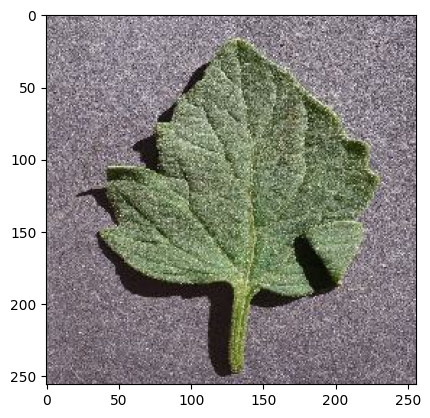

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

actual_classes = []
predicted_classes = []

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        actual_classes.append(actual_class)
        predicted_classes.append(predicted_class)

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

print("Actual Classes:", actual_classes)
print("Predicted Classes:", predicted_classes)

In [ ]:
Y_true = []
Y_pred = []

for j in range(len(test_ds)):
    for images, labels in test_ds.take(j):
        for i in range(len(labels)):

            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]]
            Y_true.append(actual_class)
            Y_pred.append(predicted_class)

1/1 [==============================] - 0s 21ms/step


Text(0.5, 100.08159722222219, 'Predicted')

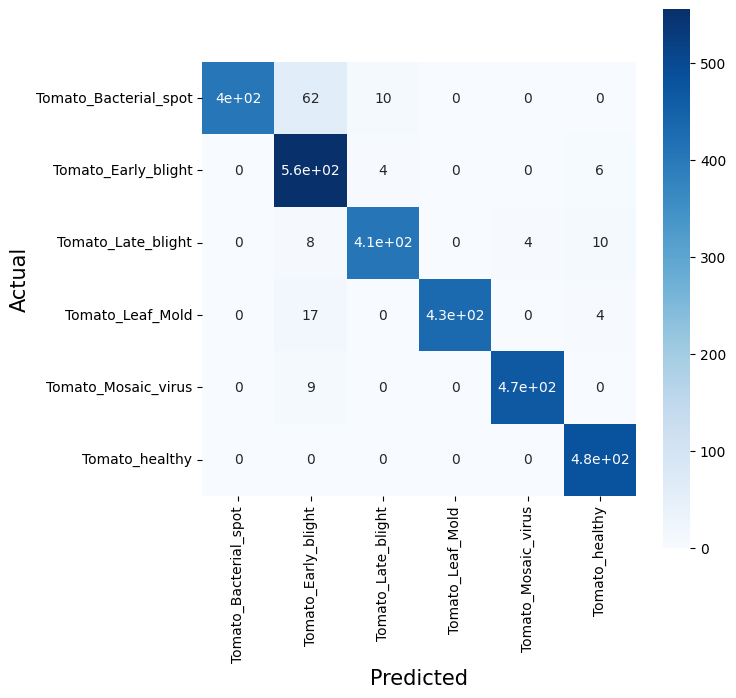

In [ ]:
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(7, 7))
ax = sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, xticklabels=class_names, yticklabels=class_names)
ax.set_ylabel('Actual', fontsize=15)
ax.set_xlabel('Predicted', fontsize=15)

1/1 [==============================] - 0s 20ms/step


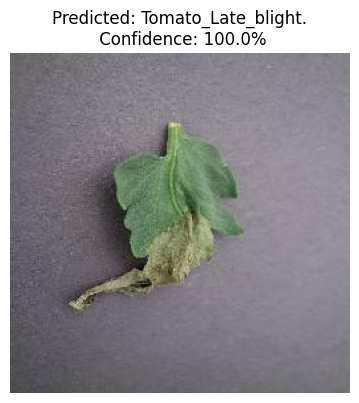

In [ ]:
im_file = urlopen("https://i.ibb.co/GJxfzx2/Late-blight-1318.jpg")
image_file = Image.open(im_file)
plt.figure(figsize=(15, 15))

# Define 'i' before using it
i = 0  # You need to set an appropriate value for 'i' based on your requirements

ax = plt.subplot(3, 3, i + 1)
plt.imshow(image_file)
predicted_class, confidence = predict(model, np.array(image_file))
plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 20ms/step


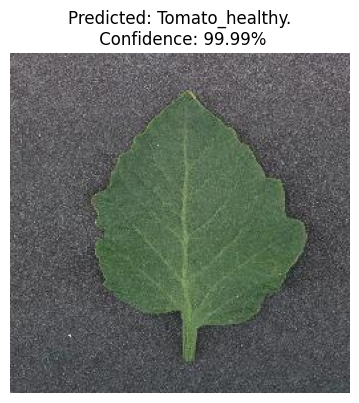

In [ ]:
im_file = urlopen("https://i.ibb.co/VB9TSMX/Healthy-1412.jpg")
image_file = Image.open(im_file)
plt.figure(figsize=(15, 15))

# Define 'i' before using it
i = 0  # You need to set an appropriate value for 'i' based on your requirements

ax = plt.subplot(3, 3, i + 1)
plt.imshow(image_file)
predicted_class, confidence = predict(model, np.array(image_file))
plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 37ms/step


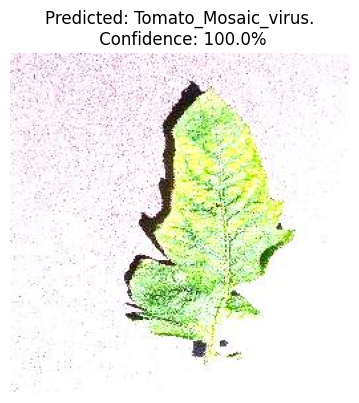

In [ ]:
im_file = urlopen("https://i.ibb.co/5W3mtnj/Mosaic-virus-1242.jpg")
image_file = Image.open(im_file)
plt.figure(figsize=(15, 15))

# Define 'i' before using it
i = 0  # You need to set an appropriate value for 'i' based on your requirements

ax = plt.subplot(3, 3, i + 1)
plt.imshow(image_file)
predicted_class, confidence = predict(model, np.array(image_file))
plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 21ms/step


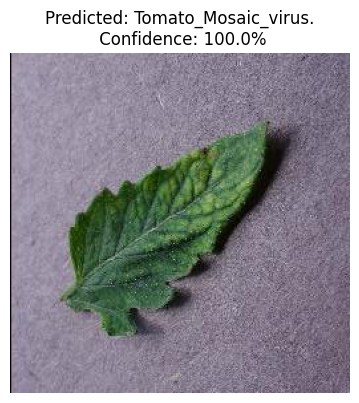

In [ ]:
im_file = urlopen("https://i.ibb.co/x8nQ2Pg/Mosaic-virus-496.jpg")
image_file = Image.open(im_file)
plt.figure(figsize=(15, 15))

# Define 'i' before using it
i = 0  # You need to set an appropriate value for 'i' based on your requirements

ax = plt.subplot(3, 3, i + 1)
plt.imshow(image_file)
predicted_class, confidence = predict(model, np.array(image_file))
plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
plt.axis("off")
plt.show()